In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgetsets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms.optimizers import *

from qiskit.utils import algorithm_globals
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization import QuadraticProgram

from qiskit.opflow import Z, I
from ibm_quantum_widgets import *
from qiskit.visualization import plot_histogram
# from qiskit.quantum_info.operators import Operator, Pauli

from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit.circuit.library import RealAmplitudes
from qiskit_optimization.converters import LinearEqualityToPenalty

from qiskit_optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## QP define

In [2]:
def operator_from_adjacency_matrix(adj_mtx):
    qubit_num = len(adj_mtx)
    
    iden = I
    for i in range(1,qubit_num):
        iden = iden^I
    
    op = iden-iden
    # print(op)
    
    for i in range(qubit_num):
        for j in range(qubit_num):
            if i > j:
                # 2ZiZj
                temp = np.ones(qubit_num)*I
                temp[i] = Z
                temp[j] = Z
                
                op_0 = temp[0]
                for k in range(1, qubit_num):
                    op_0 = op_0^temp[k]
                    
                print(op_0)
                op = op + 2*op_0
                
                # 0.5*I - 0.5*ZiZj
                if adj_mtx[i][j] == 1:
                    op = op + (0.5*iden - 0.5 * op_0)
    op = op + qubit_num * iden
        
    return op

In [3]:
def convert_to_matrix(graph):
    matrix = []
    for i in range(len(graph)): 
        matrix.append([0]*(len(graph)))
        for j in graph[i]:
            matrix[i][j] = 1
    return matrix

#the lst shows in a form of each index(each inner list) as a form of vertex,
#and each element in the inner list as the vertices that each vertex connected to.
lst = [[1,4,6],[0,2],[1,5,7],[4],[0,3,5],[2,4],[0],[2]]
print(convert_to_matrix(lst))

[[0, 1, 0, 0, 1, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0]]


In [4]:
adj_mtx = [[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 1], 
           [0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 0, 1, 0]]
# adj_mtx = [[0, 1, 0, 0, 1, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0], 
#            [1, 0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0]]
# adj_mtx = [[0. 1. 1. 1.], [1. 0. 1. 0.], [1. 1. 0. 1.], [1. 0. 1. 0.]]
op = operator_from_adjacency_matrix(adj_mtx)
op.to_matrix_op()
# print(op)
qp = QuadraticProgram()
qp.from_ising(op)
print(qp)

ZZIIIIII
ZIZIIIII
IZZIIIII
ZIIZIIII
IZIZIIII
IIZZIIII
ZIIIZIII
IZIIZIII
IIZIZIII
IIIZZIII
ZIIIIZII
IZIIIZII
IIZIIZII
IIIZIZII
IIIIZZII
ZIIIIIZI
IZIIIIZI
IIZIIIZI
IIIZIIZI
IIIIZIZI
IIIIIZZI
ZIIIIIIZ
IZIIIIIZ
IIZIIIIZ
IIIZIIIZ
IIIIZIIZ
IIIIIZIZ
IIIIIIZZ
minimize -25*x0^2 + 6*x0*x1 + 8*x0*x2 + 8*x0*x3 + 6*x0*x4 + 8*x0*x5 + 6*x0*x6 + 8*x0*x7 - 26*x1^2 + 6*x1*x2 + 8*x1*x3 + 8*x1*x4 + 8*x1*x5 + 8*x1*x6 + 8*x1*x7 - 25*x2^2 + 8*x2*x3 + 8*x2*x4 + 6*x2*x5 + 8*x2*x6 + 6*x2*x7 - 27*x3^2 + 6*x3*x4 + 8*x3*x5 + 8*x3*x6 + 8*x3*x7 - 25*x4^2 + 6*x4*x5 + 8*x4*x6 + 8*x4*x7 - 26*x5^2 + 8*x5*x6 + 8*x5*x7 - 27*x6^2 + 8*x6*x7 - 27*x7^2 + 64 (8 variables, 0 constraints, '')


## VQE

In [5]:
optimizer = SLSQP(maxiter=10000)
algorithm_globals.random_seed = 1234
seed = 11234
num = 8
backend = Aer.get_backend('statevector_simulator')

ry = TwoLocal(num, 'ry', 'cz', reps=4, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance)

vqe_meo = MinimumEigenOptimizer(vqe)

result = vqe_meo.solve(qp)

print(result.samples)

[SolutionSample(x=array([0., 0., 1., 1., 0., 1., 0., 1.]), fval=3.0, probability=0.08624486296992093, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 0., 1., 0., 0., 1., 1., 1.]), fval=3.0, probability=0.9137533679209364, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 0., 0., 0., 1., 0., 1., 1.]), fval=9.0, probability=1.0676381108367376e-06, status=<OptimizationResultStatus.SUCCESS: 0>)]


In [6]:
n = 8
penalty = 2 * n

linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

# set classical optimizer
maxiter = 1000
optimizer = COBYLA(maxiter=maxiter)
# set variational ansatz
ansatz = RealAmplitudes(n, reps=1)
m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25]  # confidence levels to be evaluated
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]

for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
    cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    vqe = VQE(
        expectation=cvar_exp,
        optimizer=optimizer,
        ansatz=ansatz,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(vqe)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: 2.0
variable values: x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=0.0, x7=1.0
status: SUCCESS

alpha = 0.5:
objective function value: 2.0
variable values: x0=1.0, x1=0.0, x2=0.0, x3=1.0, x4=1.0, x5=0.0, x6=1.0, x7=0.0
status: SUCCESS

alpha = 0.25:
objective function value: 2.0
variable values: x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=0.0, x7=1.0
status: SUCCESS



In [ ]:
x = []
prob = np.zeros([4, 10])
func = np.zeros([4, 10])

for opt in range(4):
    for it in range(1, 11):
        if opt == 0:
            optimizer = SLSQP(maxiter=1000)  
        elif opt == 1:
            optimizer = COBYLA(maxiter=1000)
        elif opt == 2:
            optimizer = NELDER_MEAD(maxiter=1000)
        elif opt == 3:
            optimizer = POWELL(maxiter=1000)

        algorithm_globals.random_seed = 1234
        seed = 12345
        backend = Aer.get_backend('statevector_simulator')
        qNum = 8
        
        ry = TwoLocal(qNum, 'ry', 'cz', reps=it, entanglement='full')
        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
        vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance)

        vqe_meo = MinimumEigenOptimizer(vqe)

        result = vqe_meo.solve(qp)

        print(result)

        prob = {}
        fval = {}
        
            
            
        for i in range(len(result.samples)):
            tmp = ""
            count = 0
            for num in range(8):
                tmp += str(int(result.samples[i].x[num]))
                count += int(result.samples[i].x[num])
            
            prob[tmp] = result.samples[i].probability
            fval[tmp] = result.samples[i].fval


        np.save(f"data/VQE/prob_all_opt{opt}_layer{it}.npy", prob)
        np.save(f"data/VQE/fval_all_opt{opt}_layer{it}.npy", fval)




fval=3.0, x0=1.0, x1=0.0, x2=0.0, x3=1.0, x4=1.0, x5=1.0, x6=0.0, x7=0.0, status=SUCCESS


#### Plot

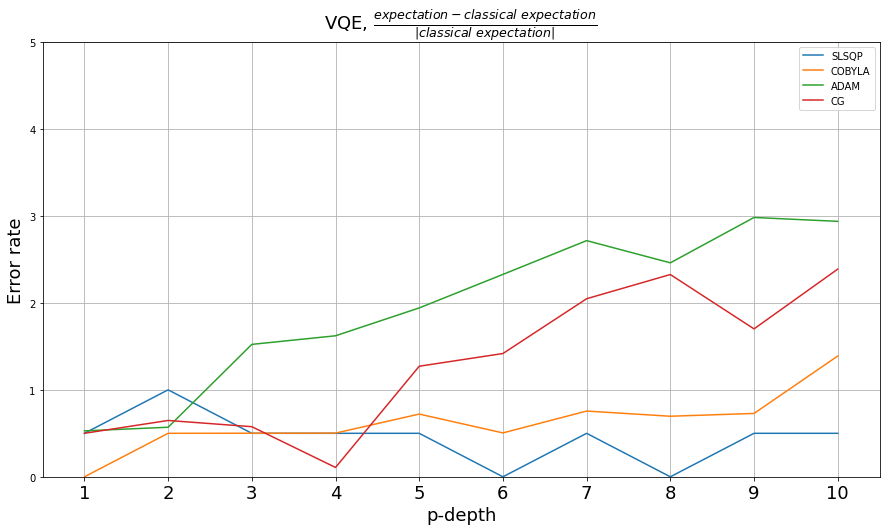

In [72]:
classical_exp = 2
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])
for opt in range(4):
    for it in range(1, 11):
        df = np.load(f"data/VQE/prob_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        df2 = np.load(f"data/VQE/fval_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        probability[opt, it-1] = df.get('10011010', 0)
        probability[opt, it-1] += df.get('01100101', 0)
        cost[opt, it-1] = df2.get('10011010', 0)
        for key in df:
            expectation[opt, it-1] += df[key] * df2[key]
        

alpha = (expectation - classical_exp) / np.abs(classical_exp)

plt.figure(figsize=(10,8))
for opt in range(4):
    plt.plot(pdepth, probability[opt])
plt.legend(["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
plt.xlim(0.5, 10.5)
plt.ylim(0, 1)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title("VQE, Probability of Finding Right Answer\n (10011010 or 01100101)", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/VQE/prob.png", bbox_inches='tight',pad_inches = 0,dpi=300)
plt.close()

plt.figure(figsize=(10,8))
for opt in range(4):
    plt.plot(pdepth, expectation[opt])
plt.legend(["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
plt.xlim(0.5, 10.5)
plt.ylim(2, 8)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title("VQE, Expectation of Cost Function\n (Right Answer: 2)", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Expectation Value", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/VQE/expect.png", bbox_inches='tight',pad_inches = 0,dpi=300) 
plt.close()

plt.figure(figsize=(15,8))
for opt in range(4):
    plt.plot(pdepth, alpha[opt])
plt.legend(["SLSQP", "COBYLA", "ADAM", "CG", "Gradient descent"])
plt.xlim(0.5, 10.5)
plt.ylim(0, 5)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title(r"VQE, $\frac{expectation - classical\ expectation}{|classical\ expectation|}$", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Error rate", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/VQE/alpha.png", bbox_inches='tight',pad_inches = 0,dpi=300) 
plt.show()
plt.close()

In [ ]:
dd = np.load(f"data/QAOA/prob_all_opt0_layer1.npy",allow_pickle='TRUE').item()
new_ans = {}
x = []
for key in dd:
    tmp = 0
    for i in range(8):
        tmp += int(key[i])
    if tmp == 4:
        x.append(key)

for it in range(1,11):
    df = np.load(f"data/VQE/prob_all_opt0_layer{it}.npy",allow_pickle='TRUE').item()
    df2 = np.load(f"data/VQE/prob_all_opt1_layer{it}.npy",allow_pickle='TRUE').item()
    df3 = np.load(f"data/VQE/prob_all_opt2_layer{it}.npy",allow_pickle='TRUE').item()
    df4 = np.load(f"data/VQE/prob_all_opt3_layer{it}.npy",allow_pickle='TRUE').item()

    y = np.zeros(len(x))
    y2 = np.zeros(len(x))
    y3 = np.zeros(len(x))
    y4 = np.zeros(len(x))

    for i in range(len(x)):
        y[i] = float(df.get(x[i], 0.))
        y2[i] = float(df2.get(x[i], 0.))
        y3[i] = float(df3.get(x[i], 0.))
        y4[i] = float(df4.get(x[i], 0.))


    wid = 0.5
    X = np.linspace(0, 150, len(x))
    plt.figure(figsize=(25, 8))
    plt.xlim(-2, 155)
    # plt.ylim(0, 1)
    plt.title(f"VQE, Reps={it}", fontsize=16)
    plt.bar(X, y, width=wid, color='r')
    plt.bar(X+0.5, y2, width=wid, color='b')
    plt.bar(X+1, y3, width=wid, color='k')
    plt.bar(X+1.5, y4, width=wid, color='g')
    plt.legend(labels=["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
    plt.xticks(X, x)
    plt.ylabel("Probabilities", fontsize=16)

    plt.xticks(rotation=90, fontsize=16)
    plt.savefig(f"graph/VQE/few_{it}.png", bbox_inches='tight',pad_inches = 0,dpi=200)
    plt.show()
    plt.close()

## Classical

In [ ]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

## QAOA

In [ ]:
adj_mtx = [[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 1], 
           [0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1], [0, 1, 0, 1, 0, 0, 1, 0]]
# adj_mtx = [[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0]]
op = operator_from_adjacency_matrix(adj_mtx)
op.to_matrix_op()
# print(op)
qp = QuadraticProgram()
qp.from_ising(op)

In [ ]:
optimizer = SLSQP(maxiter=10000)
algorithm_globals.random_seed = 1234
seed = 11234
backend = Aer.get_backend('statevector_simulator')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa = QAOA(optimizer=optimizer, reps=3, quantum_instance=quantum_instance)
meo = MinimumEigenOptimizer(qaoa)

qaoa_meo = MinimumEigenOptimizer(qaoa)

result = qaoa_meo.solve(qp)

print(result.samples)
print(result)

In [ ]:
x = []
prob = np.zeros([4, 10])
func = np.zeros([4, 10])

for opt in range(4):
    for it in range(1, 11):
        if opt == 0:
            optimizer = SLSQP(maxiter=1000)  
        elif opt == 1:
            optimizer = COBYLA(maxiter=1000)
        elif opt == 2:
            optimizer = NELDER_MEAD(maxiter=1000)
        elif opt == 3:
            optimizer = POWELL(maxiter=1000)

        algorithm_globals.random_seed = 1234
        seed = 12345
        backend = Aer.get_backend('statevector_simulator')
        qNum = 8
        
        qaoa = QAOA(optimizer=optimizer, reps=3, quantum_instance=quantum_instance)
        meo = MinimumEigenOptimizer(qaoa)
        qaoa_meo = MinimumEigenOptimizer(qaoa)

        result = qaoa_meo.solve(qp)

        print(result)

        prob = {}
        fval = {}
            
            
        for i in range(len(result.samples)):
            tmp = ""
            count = 0
            for num in range(8):
                tmp += str(int(result.samples[i].x[num]))
                count += int(result.samples[i].x[num])
            
            prob[tmp] = result.samples[i].probability
            fval[tmp] = result.samples[i].fval


        np.save(f"data/QAOA/prob_all_opt{opt}_layer{it}.npy", prob)
        np.save(f"data/QAOA/fval_all_opt{opt}_layer{it}.npy", fval)

In [ ]:

prob = {}
fval = {}
print(result.samples[0].x)
for i in range(len(result.samples)):
    tmp = ""
    count = 0
    for num in range(8):
        tmp += str(int(result.samples[i].x[num]))
        count += int(result.samples[i].x[num])
    
    if count == 4:
        prob[tmp] = result.samples[i].probability
        fval[tmp] = result.samples[i].fval

print(fval)


#### Plot

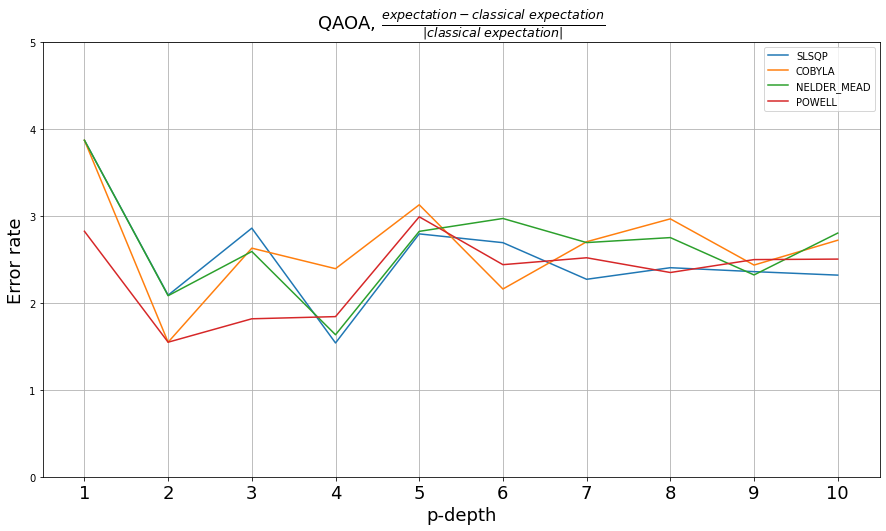

In [73]:
classical_exp = 2
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])
for opt in range(4):
    for it in range(1, 11):
        df = np.load(f"data/QAOA/prob_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        df2 = np.load(f"data/QAOA/fval_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        probability[opt, it-1] = df.get('10011010', 0)
        probability[opt, it-1] += df.get('01100101', 0)
        cost[opt, it-1] = df2.get('10011010', 0)
        for key in df:
            expectation[opt, it-1] += df[key] * df2[key]
        

alpha = (expectation - classical_exp) / np.abs(classical_exp)

plt.figure(figsize=(10,8))
for opt in range(4):
    plt.plot(pdepth, probability[opt])
plt.legend(["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
plt.xlim(0.5, 10.5)
plt.ylim(0, 1)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title("QAOA, Probability of Finding Right Answer\n (10011010 or 01100101)", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/QAOA/prob.png", bbox_inches='tight',pad_inches = 0,dpi=300)
plt.close()

plt.figure(figsize=(10,8))
for opt in range(4):
    plt.plot(pdepth, expectation[opt])
plt.legend(["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
plt.xlim(0.5, 10.5)
# plt.ylim(2, 8)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title("QAOA, Expectation of Cost Function\n (Right Answer: 2)", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Expectation Value", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/QAOA/expect.png", bbox_inches='tight',pad_inches = 0,dpi=300) 
plt.close()

plt.figure(figsize=(15,8))
for opt in range(4):
    plt.plot(pdepth, alpha[opt])
plt.legend(["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
plt.xlim(0.5, 10.5)
plt.ylim(0, 5)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title(r"QAOA, $\frac{expectation - classical\ expectation}{|classical\ expectation|}$", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Error rate", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/QAOA/alpha.png", bbox_inches='tight',pad_inches = 0,dpi=300) 
plt.show()
plt.close()

## Grover

In [ ]:
iter_arr = np.linspace(1,8,8)
ratio_arr = np.linspace(0.2,2,5)
op = operator_from_adjacency_matrix(adj_mtx)
for iter_idx in range(len(iter_arr)):
        
    iter_num = iter_arr[iter_idx]
    qp = QuadraticProgram()
    qp.from_ising(op)
    backend = Aer.get_backend('statevector_simulator')

    grover_optimizer = GroverOptimizer(8, num_iterations=iter_num, quantum_instance=backend)
    result = grover_optimizer.solve(qp)
    print(result.prettyprint())

    prob = {}
    fval = {}


    for i in range(len(result.samples)):
        tmp = ""
        count = 0
        for num in range(8):
            tmp += str(int(result.samples[i].x[num]))
            count += int(result.samples[i].x[num])

        prob[tmp] = result.samples[i].probability
        fval[tmp] = result.samples[i].fval


    np.save(f"data/GROVER/prob_iter{iter_num}.npy", prob)
    np.save(f"data/GROVER/fval_iter{iter_num}.npy", fval)

In [ ]:
grover_optimizer = GroverOptimizer(8, num_iterations=15, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print(results.prettyprint())

In [ ]:
def opt_ans(result_dict,adj_mtx):
    # find the optimal term
    qubit_num = len(adj_mtx)
    cut_dict = {}
    for bitstr in result_dict:
        cut = 0
        ans = bitstr
    # reverse the order of qubit so that ith qubit correspond to ith term
        ans = list(ans)
        ans.reverse()

        for i in range(qubit_num):
            for j in range(qubit_num):
                if i>j and adj_mtx[i][j] == 1 and ans[i] != ans[j]:
                    cut += 1
                    
        cut_dict[bitstr] = cut
    return cut_dict

opt, it = 0, 1
df = np.load(f"data/QAOA/prob_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
# opt_ans(, adj_mtx)


ans = opt_ans(df, adj_mtx)
new_ans = {}
for key in ans:
    tmp = 0
    for i in range(8):
        tmp += int(key[i])
    if tmp == 4:
        new_ans[key] = ans[key]
print(new_ans)

In [ ]:
dd = np.load(f"data/QAOA/prob_all_opt0_layer1.npy",allow_pickle='TRUE').item()
new_ans = {}
x = []
for key in dd:
    tmp = 0
    for i in range(8):
        tmp += int(key[i])
    if tmp == 4:
        x.append(key)

for it in range(1,11):
    df = np.load(f"data/QAOA/prob_all_opt0_layer{it}.npy",allow_pickle='TRUE').item()
    df2 = np.load(f"data/QAOA/prob_all_opt1_layer{it}.npy",allow_pickle='TRUE').item()
    df3 = np.load(f"data/QAOA/prob_all_opt2_layer{it}.npy",allow_pickle='TRUE').item()
    df4 = np.load(f"data/QAOA/prob_all_opt3_layer{it}.npy",allow_pickle='TRUE').item()

    y = np.zeros(len(x))
    y2 = np.zeros(len(x))
    y3 = np.zeros(len(x))
    y4 = np.zeros(len(x))

    for i in range(len(x)):
        y[i] = float(df.get(x[i], 0.))
        y2[i] = float(df2.get(x[i], 0.))
        y3[i] = float(df3.get(x[i], 0.))
        y4[i] = float(df4.get(x[i], 0.))


    wid = 0.5
    X = np.linspace(0, 150, len(x))
    plt.figure(figsize=(25, 8))
    plt.xlim(-2, 155)
    # plt.ylim(0, 1)
    plt.title(f"QAOA, Reps={it}", fontsize=16)
    plt.bar(X, y, width=wid, color='r')
    plt.bar(X+0.5, y2, width=wid, color='b')
    plt.bar(X+1, y3, width=wid, color='k')
    plt.bar(X+1.5, y4, width=wid, color='g')
    plt.legend(labels=["SLSQP", "COBYLA", "NELDER_MEAD", "POWELL"])
    plt.xticks(X, x)
    plt.ylabel("Probabilities", fontsize=16)

    plt.xticks(rotation=90, fontsize=16)
    plt.savefig(f"graph/QAOA/few_{it}.png", bbox_inches='tight',pad_inches = 0,dpi=200)
    plt.show()
    plt.close()

In [ ]:
!ls

In [ ]:
!tar -czf data/GROVER.tar.gz data/GROVER

## Normalized Plot

#### VQE

##### Processed

In [7]:
classical_exp = np.load("data/normalized/classical_exp_arr.npy")
print(classical_exp)
classical_exp_arr = np.zeros([50])
for i in range(50):
    if i < 10:
        classical_exp_arr[i] = classical_exp[0]
    elif 10 <= i < 20:
        classical_exp_arr[i] = classical_exp[1]
    elif 20 <= i < 30:
        classical_exp_arr[i] = classical_exp[2]
    elif 30 <= i < 40:
        classical_exp_arr[i] = classical_exp[3]
    else:
        classical_exp_arr[i] = classical_exp[4]
print(classical_exp_arr)

[0.2  0.25 0.25 0.25 0.25]
[0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [25]:
df = np.load(f"data/normalized/VQE/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(0, 1):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/VQE/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/VQE/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 0:
    np.savetxt("data/normalized/VQE_output/probability.csv", output_prob, delimiter=",")
    np.savetxt("data/normalized/VQE_output/expectation.csv", output_expectation, delimiter=",")
    np.savetxt("data/normalized/VQE_output/error_rate.csv", output_error_rate, delimiter=",")
    

In [26]:
df = np.load(f"data/normalized/VQE/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(1, 2):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/VQE/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/VQE/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 1:
    np.savetxt("data/normalized/VQE_output/probability_2.csv", output_prob, delimiter=",")
    np.savetxt("data/normalized/VQE_output/expectation_2.csv", output_expectation, delimiter=",")
    np.savetxt("data/normalized/VQE_output/error_rate_2.csv", output_error_rate, delimiter=",")
    

##### reprocessed

In [35]:
df = np.load(f"data/normalized/VQE/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(0, 1):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/VQE/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/VQE/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 0:
    np.save("data/normalized/VQE_output_reprocessed/probability.npy", output_prob)
    np.save("data/normalized/VQE_output_reprocessed/expectation.npy", output_expectation,)
    np.save("data/normalized/VQE_output_reprocessed/error_rate.npy", output_error_rate)
    

In [36]:
df = np.load(f"data/normalized/VQE/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(1, 2):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/VQE/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/VQE/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 1:
    np.save("data/normalized/VQE_output_reprocessed/probability_2.npy", output_prob)
    np.save("data/normalized/VQE_output_reprocessed/expectation_2.npy", output_expectation)
    np.save("data/normalized/VQE_output_reprocessed/error_rate_2.npy", output_error_rate)
    

#### QAOA

##### Processed

In [28]:
df = np.load(f"data/normalized/QAOA/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(0, 1):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/QAOA/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/QAOA/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 0:
    np.savetxt("data/normalized/QAOA_output/probability.csv", output_prob, delimiter=",")
    np.savetxt("data/normalized/QAOA_output/expectation.csv", output_expectation, delimiter=",")
    np.savetxt("data/normalized/QAOA_output/error_rate.csv", output_error_rate, delimiter=",")
    

In [29]:
df = np.load(f"data/normalized/QAOA/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(1, 2):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/QAOA/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/QAOA/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 1:
    np.savetxt("data/normalized/QAOA_output/probability_2.csv", output_prob, delimiter=",")
    np.savetxt("data/normalized/QAOA_output/expectation_2.csv", output_expectation, delimiter=",")
    np.savetxt("data/normalized/QAOA_output/error_rate_2.csv", output_error_rate, delimiter=",")
    

##### Reprocessed

In [64]:
df = np.load(f"data/normalized/QAOA/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(0, 1):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/QAOA/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/QAOA/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 0:
    np.save("data/normalized/QAOA_output_reprocessed/probability.npy", output_prob)
    np.save("data/normalized/QAOA_output_reprocessed/expectation.npy", output_expectation)
    np.save("data/normalized/QAOA_output_reprocessed/error_rate.npy", output_error_rate)
    

In [65]:
df = np.load(f"data/normalized/QAOA/prob_all_opt{0}_layer{1}_ratio{0.2}.npy",allow_pickle='TRUE').item()

classical_exp = np.load("data/normalized/classical_exp_arr.npy")
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])

ratMax = [0.2, 0.65, 1.1, 1.55, 2.0]
output_prob = np.zeros([50, 3])   
output_expectation = np.zeros([50, 3])
output_error_rate = np.zeros([50, 3])
count = 0
for opt in range(1, 2):
    for it in range(1, 11):
        for ra in ratMax:
            df = np.load(f"data/normalized/QAOA/prob_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            df2 = np.load(f"data/normalized/QAOA/fval_all_opt{opt}_layer{it}_ratio{ra}.npy",allow_pickle='TRUE').item()
            output_prob[count, 0] = output_expectation[count, 0] = output_error_rate[count, 0] = it
            output_prob[count, 1] = output_expectation[count, 1] = output_error_rate[count, 1] = ra
            output_prob[count, 2] = df.get('10011010', 0) + df.get('01100101', 0)
            
            for key in df:
                output_expectation[count, 2] += df[key] * df2[key]
            count += 1

for i in range(50):
    output_error_rate[i, 2] = (output_expectation[i, 2] - classical_exp_arr[i]) / np.abs(classical_exp_arr[i])
    
# print(output_error_rate)
if opt == 1:
    np.save("data/normalized/QAOA_output_reprocessed/probability_2.npy", output_prob)
    np.save("data/normalized/QAOA_output_reprocessed/expectation_2.npy", output_expectation)
    np.save("data/normalized/QAOA_output_reprocessed/error_rate_2.npy", output_error_rate)
    

#### Difference Plot

##### VQE

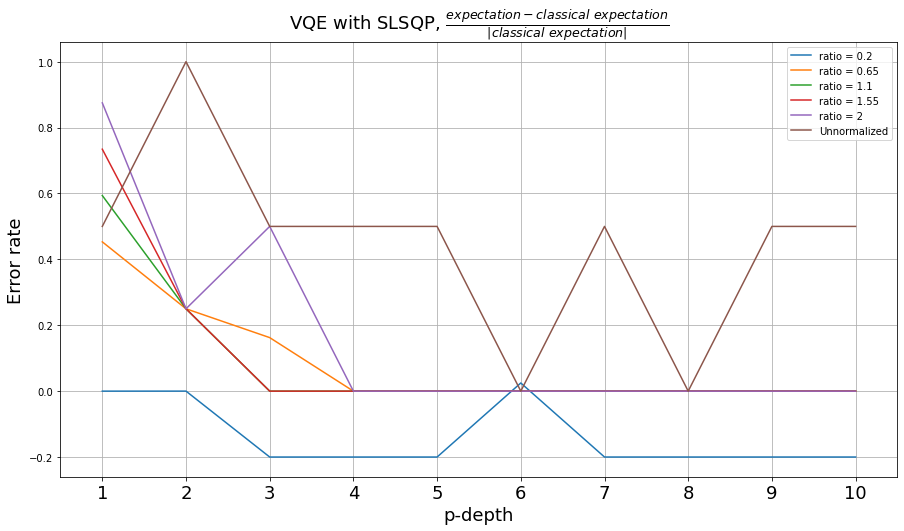

In [69]:
normalized_error_rate = np.load("data/normalized/VQE_output_reprocessed/error_rate.npy")
# df = pd.read_csv('data/normalized/VQE_output/probability.csv', sep=',',header=None)
x = np.arange(1, 11)
y = np.zeros([5, 10])
ratio_arr = np.linspace(0.2,2,5)
# print(normalized_error_rate)

normalized_error_rate = normalized_error_rate[:, 2:]
for i in range(5):
    y[i] = normalized_error_rate[i::5].T


    
    
classical_exp = 2
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])
for opt in range(4):
    for it in range(1, 11):
        df = np.load(f"data/VQE/prob_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        df2 = np.load(f"data/VQE/fval_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        probability[opt, it-1] = df.get('10011010', 0)
        probability[opt, it-1] += df.get('01100101', 0)
        cost[opt, it-1] = df2.get('10011010', 0)
        for key in df:
            expectation[opt, it-1] += df[key] * df2[key]
        

alpha = (expectation - classical_exp) / np.abs(classical_exp)

plt.figure(figsize=(15,8))
for i in range(5):
    plt.plot(x, y[i])
plt.plot(x, alpha[0])
plt.legend(["ratio = 0.2", "ratio = 0.65", "ratio = 1.1", "ratio = 1.55", "ratio = 2", "Unnormalized"])
plt.xlim(0.5, 10.5)
# plt.ylim(0, 5)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title(r"VQE with SLSQP, $\frac{expectation - classical\ expectation}{|classical\ expectation|}$", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Error rate", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/VQE_compare.png", bbox_inches='tight',pad_inches = 0,dpi=300) 
plt.show()
plt.close()


##### QAOA

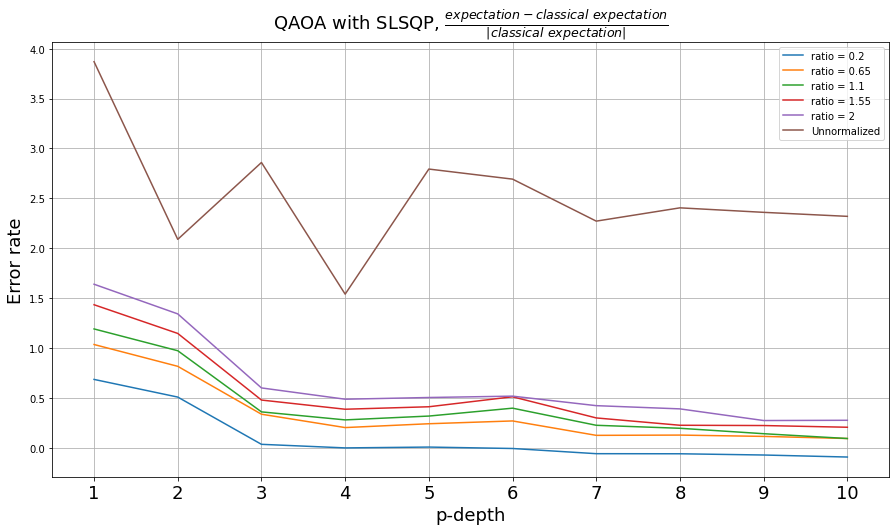

In [68]:
normalized_error_rate = np.load("data/normalized/QAOA_output_reprocessed/error_rate.npy")
# df = pd.read_csv('data/normalized/VQE_output/probability.csv', sep=',',header=None)
x = np.arange(1, 11)
y = np.zeros([5, 10])
ratio_arr = np.linspace(0.2,2,5)
# print(normalized_error_rate)

normalized_error_rate = normalized_error_rate[:, 2:]
for i in range(5):
    y[i] = normalized_error_rate[i::5].T

    
classical_exp = 2
probability = np.zeros([4, 10])
cost = np.zeros([4, 10])
pdepth = np.arange(1, 11)
expectation = np.zeros([4, 10])
for opt in range(4):
    for it in range(1, 11):
        df = np.load(f"data/QAOA/prob_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        df2 = np.load(f"data/QAOA/fval_all_opt{opt}_layer{it}.npy",allow_pickle='TRUE').item()
        probability[opt, it-1] = df.get('10011010', 0)
        probability[opt, it-1] += df.get('01100101', 0)
        cost[opt, it-1] = df2.get('10011010', 0)
        for key in df:
            expectation[opt, it-1] += df[key] * df2[key]
        

alpha = (expectation - classical_exp) / np.abs(classical_exp)

plt.figure(figsize=(15,8))
for i in range(5):
    plt.plot(x, y[i])
plt.plot(x, alpha[0])
plt.legend(["ratio = 0.2", "ratio = 0.65", "ratio = 1.1", "ratio = 1.55", "ratio = 2", "Unnormalized"])
plt.xlim(0.5, 10.5)
# plt.ylim(0, 5)
plt.xticks(np.arange(1, 11), ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], fontsize=18)
plt.title(r"QAOA with SLSQP, $\frac{expectation - classical\ expectation}{|classical\ expectation|}$", fontsize=18)
plt.xlabel("p-depth", fontsize=18)
plt.ylabel("Error rate", fontsize=18)
plt.grid("--")
plt.savefig(f"graph/QAOA_compare.png", bbox_inches='tight',pad_inches = 0,dpi=300) 
plt.show()
plt.close()
